# Detailed showcase of the space shared control algorithm

Aims to show how it behaves in certain constrained cases to highlight the decisions it makes

## Loading and setting up all elements


In [1]:
import sys
import time
sys.path.append("..")

from simulation_evaluation.microgrid_simulator import ControllEnvironment
from simulation_evaluation.microgrid_ga_v2 import MicrogridGA
from simulation_evaluation.controller_offline import SpaceShareController
from simulation_evaluation.protection_controller import ProtectionController
day_nr=18
precision=1
battery_power=4.1
battery_max_discharge = 40.0
pv_scale=0.4
priorities=[1, 2, 3, 4, 5, 6, 7]

#Custom Utility Function defined based on the Microgrid Slides
def evaluate_individual(individual):
    SoC_max = 100.0
    SoC_min = 40.0
    P_rated = 3000
    wb=we=0.125
    wp=wd=0.25
    for index, row in individual.iterrows():
        util = 0.0
        #Battery Health
        SoC = row['Battery_SoC']
        P_Cons = row['Consumed_Energy']
        Fb_t = (SoC-SoC_min)/(SoC_max-SoC_min)+P_Cons/P_rated
        #Efficiency
        P_System_Load = row['System_Load']
        P_PV_Gen = row['Generated_Energy']
        Fe_t = (P_Cons-P_System_Load)/P_Cons+P_Cons/(P_Cons+P_PV_Gen)
        #Penalty
        Fp_t =  1.0 if row['Battery_SoC']>SoC_min else 0.0
        #Dissatisafaction
        priority_keys = [ x for x in list(individual.keys()) if "_Priority" in x]
        Fd_t = 0.0
        for x in priority_keys:
            Fd_t+=(row[x.split("_Priority")[0]+"_Quota"]*1/row[x])/len(priority_keys)
        #Combine with weights                                  
        individual.loc[index,"Util"] = wb*Fb_t+we*Fe_t+wp*Fp_t+wd*Fd_t
    return sum(individual['Util']) / len(individual)

----------Initialising Data-Set-----------
Starting Scenario


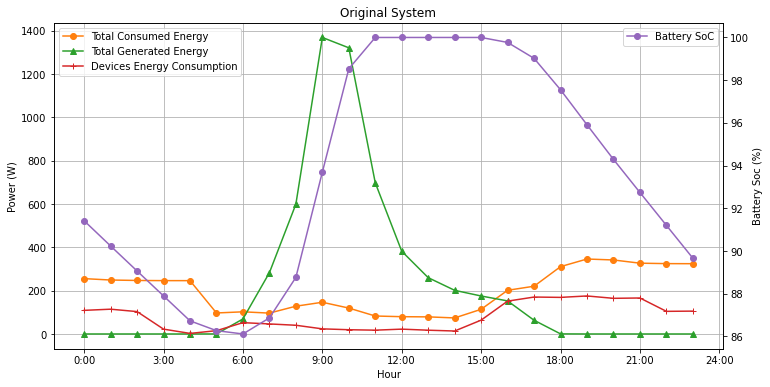

----------Scaled Data-Set-----------
Starting Scenario


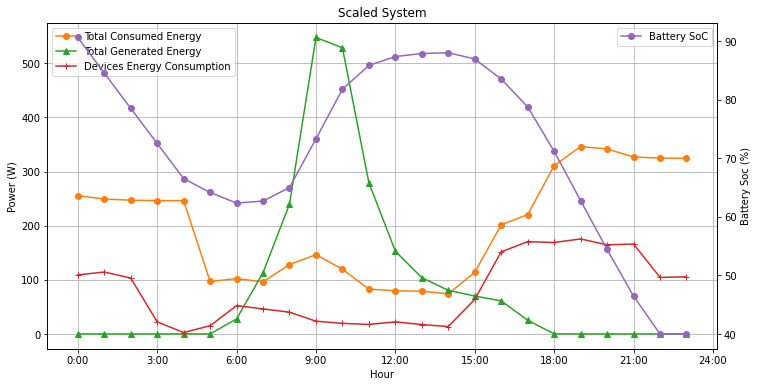

In [3]:
#Initialise
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
print("----------Initialising Data-Set-----------")
test_env = ControllEnvironment(day_nr=day_nr, actual_hour=0, battery_power=21.1, pv_scale=1.0, priorities=priorities)
print("Starting Scenario")
start_scenario = test_env.get_starting_scenario()

fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(start_scenario.index,start_scenario["Consumed_Energy"],'-o',label="Total Consumed Energy",color='C1')
ax.plot(start_scenario.index,start_scenario["Generated_Energy"],'-^',label="Total Generated Energy",color='C2')
ax.plot(start_scenario.index,start_scenario["Consumed_Energy"]-start_scenario["System_Load"],'-+',label="Devices Energy Consumption",color='C3')
ax.legend(loc="upper left")
plt.title("Original System")
ax.set_xlabel('Hour')
ax.set_ylabel('Power (W)')
ax.set_xticklabels([str(x*3)+":00" for x in range(0,12)])
ax.grid()
ax2 = ax.twinx()
ax2.plot(start_scenario.index,start_scenario["Battery_SoC"],'-o',label="Battery SoC",color='C4')
ax2.legend(loc="upper right")
ax2.set_xticklabels([str(x*3)+":00" for x in range(0,12)])
ax2.set_ylabel('Battery Soc (%)')
plt.show()


print("----------Scaled Data-Set-----------")
test_env = ControllEnvironment(day_nr=day_nr, actual_hour=0, battery_power=battery_power, pv_scale=pv_scale, priorities=priorities)
print("Starting Scenario")
start_scenario = test_env.get_starting_scenario()

fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(start_scenario.index,start_scenario["Consumed_Energy"],'-o',label="Total Consumed Energy",color='C1')
ax.plot(start_scenario.index,start_scenario["Generated_Energy"],'-^',label="Total Generated Energy",color='C2')
ax.plot(start_scenario.index,start_scenario["Consumed_Energy"]-start_scenario["System_Load"],'-+',label="Devices Energy Consumption",color='C3')
ax.legend(loc="upper left")
plt.title("Scaled System")
ax.set_xlabel('Hour')
ax.set_ylabel('Power (W)')
ax.set_xticklabels([str(x*3)+":00" for x in range(0,12)])
ax.grid()
ax2 = ax.twinx()
ax2.plot(start_scenario.index,start_scenario["Battery_SoC"],'-o',label="Battery SoC",color='C4')
ax2.legend(loc="upper right")
ax2.set_xticklabels([str(x*3)+":00" for x in range(0,12)])
ax2.set_ylabel('Battery Soc (%)')
plt.show()




# Run on the data based on the existing Safety Controller on the System

In [4]:
## Safety Controller Run
start_time = time.time()
protection_controller = ProtectionController(day_nr=day_nr, precision=precision, battery_power=battery_power, 
                                               battery_max_discharge = battery_max_discharge,
                                               pv_scale=pv_scale,priorities=priorities)

#Utility is only used to calculate final result with this methid
protection_controller.evaluate_individual = evaluate_individual

protection_util = protection_controller.run()
print("Protection Util: ",protection_util)
prot_time = (time.time()-start_time)
print("Total time: ",prot_time)

-------Energy State--------
Generated energy: 2230.2661042700174
System Load: 2869.5698831237137
Battery SoC: 96.89867886178861
Remaining Energy: 2332.845833333333
Priorities:  {1: 'Nursery1_Lights_Quota', 2: 'Nursery1_Sockets_Quota', 3: 'Nursery2_Lights_Quota', 4: 'Nursery2_Sockets_Quota', 5: 'Playground_Lights_Quota', 6: 'Playground_Sockets_Quota', 7: 'Streetlights_Quota'}
------------------------------------------------
For Hour: 0
Consumed Energy:  255.583333333333  System Load:  146.53479556953587  Generated Energy: 0.0  Device Energy: 109.04853776379713  EnergyDiff:  -255.583333333333  Battery: SoC: 96.89867886178861 Energy_Left: 2.332845833333333
Battery  Energy Available: SoC: 90.66493902439025 Energy_Left: 2.0772625000000002
Resulting Fraction:  1.0
------------------------------------------------
For Hour: 1
Consumed Energy:  249.133333333333  System Load:  134.6843429667551  Generated Energy: 0.0  Device Energy: 114.4489903665779  EnergyDiff:  -249.133333333333  Battery: SoC

## Run on the data based on the Space Shared controller proposed by the team. 

In [5]:
#Basic Controller Run
start_time = time.time()
space_shared_controller = SpaceShareController(day_nr=day_nr, precision=precision, battery_power=battery_power, 
                                               battery_max_discharge = battery_max_discharge,
                                               pv_scale=pv_scale,priorities=priorities)

#Utility is only used to calculate final result with this methid
space_shared_controller.evaluate_individual = evaluate_individual
spaceshared_util = space_shared_controller.run()
space_time = (time.time()-start_time)
protection_util = protection_controller.run()
print("Space Shared Util: ",spaceshared_util)
print("Total time: ",space_time)

-------Energy State--------
2.332845833333333
Generated energy: 2230.2661042700174
System Load: 2869.5698831237137
Battery SoC: 96.89867886178861
Remaining Energy: 1693.5420544796366
Priorities:  {1: 'Nursery1_Lights_Quota', 2: 'Nursery1_Sockets_Quota', 3: 'Nursery2_Lights_Quota', 4: 'Nursery2_Sockets_Quota', 5: 'Playground_Lights_Quota', 6: 'Playground_Sockets_Quota', 7: 'Streetlights_Quota'}
------------------------------------------------
For Device: Nursery1_Lights_Quota with energy avialable: 1693.5420544796366
Used Energy:  221.1207786075036
Remaining Energy:  1472.421275872133
Result: 1472.421275872133 Fraction:  1.0
------------------------------------------------
For Device: Nursery1_Sockets_Quota with energy avialable: 1472.421275872133
Used Energy:  0.0
Remaining Energy:  1472.421275872133
Result: 1472.421275872133 Fraction:  1.0
------------------------------------------------
For Device: Nursery2_Lights_Quota with energy avialable: 1472.421275872133
Used Energy:  424.62629

## Figures and Plots to showcase the Results

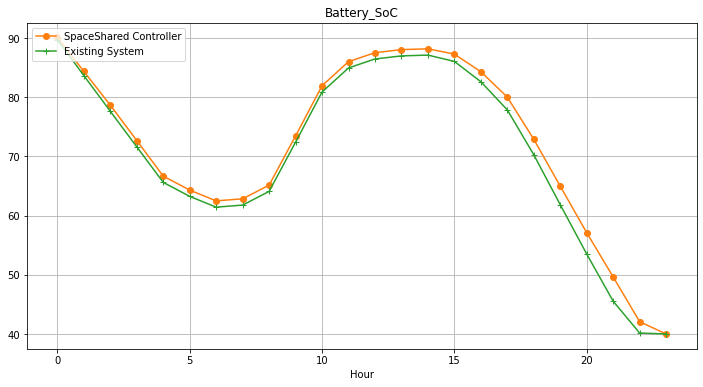

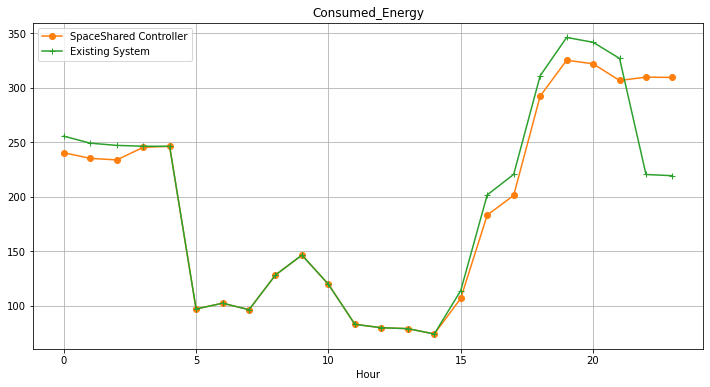

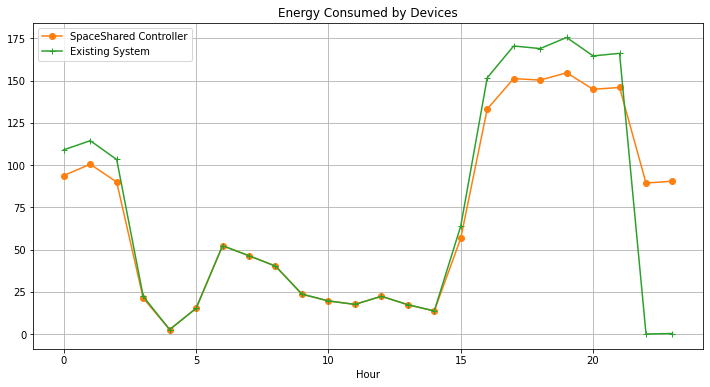

In [8]:
import pandas as pd
import random
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


spaceshare_indi = space_shared_controller.get_deployment()

protection_indi = protection_controller.get_deployment()

parameters = ["Battery_SoC","Consumed_Energy"]
for p in parameters:    
    fig,ax = plt.subplots(1,1,figsize=(12,6))
    plt.title(p)
    ax.plot(spaceshare_indi.index,spaceshare_indi[p],'-o',label="SpaceShared Controller",color='C1')
    ax.plot(protection_indi.index,protection_indi[p],'-+',label="Existing System",color='C2')
    ax.legend(loc="upper left")
    ax.set_xlabel('Hour')
    ax.grid()
    plt.show()
#Device Energy
fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.title("Energy Consumed by Devices")
ax.plot(spaceshare_indi.index,spaceshare_indi["Consumed_Energy"]-spaceshare_indi["System_Load"],'-o',label="SpaceShared Controller",color='C1')
ax.plot(protection_indi.index,protection_indi["Consumed_Energy"]-protection_indi["System_Load"],'-+',label="Existing System",color='C2')
ax.set_xlabel('Hour')
ax.legend(loc="upper left")
ax.grid()
plt.show()

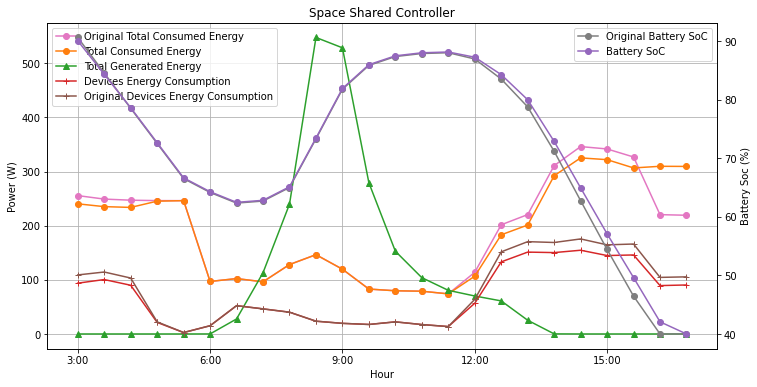

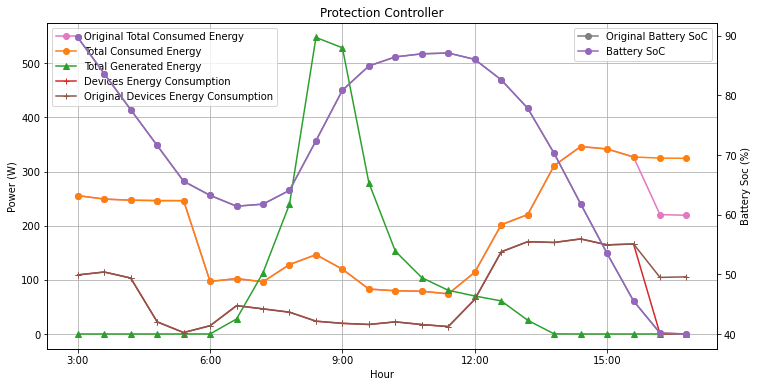

In [16]:
#Initialise
import random
import pandas as pd
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.title(p)
ax.plot(protection_indi.index,protection_indi["Consumed_Energy"],'-o',label="Original Total Consumed Energy",color='C6')
ax.plot(spaceshare_indi.index,spaceshare_indi["Consumed_Energy"],'-o',label="Total Consumed Energy",color='C1')
ax.plot(spaceshare_indi.index,spaceshare_indi["Generated_Energy"],'-^',label="Total Generated Energy",color='C2')
ax.plot(spaceshare_indi.index,spaceshare_indi["Consumed_Energy"]-spaceshare_indi["System_Load"],'-+',label="Devices Energy Consumption",color='C3')
ax.plot(protection_indi.index,start_scenario["Consumed_Energy"]-start_scenario["System_Load"],'-+',label="Original Devices Energy Consumption",color='C5')
ax.legend(loc="upper left")
plt.title("Space Shared Controller")
ax.set_xlabel('Hour')
ax.set_ylabel('Power (W)')
ax.set_xticklabels([str(x*3)+":00" for x in range(0,12)])
ax.grid()
ax2 = ax.twinx()
ax2.plot(protection_indi.index,start_scenario["Battery_SoC"],'-o',label="Original Battery SoC",color='C7')
ax2.plot(spaceshare_indi.index,spaceshare_indi["Battery_SoC"],'-o',label="Battery SoC",color='C4')
ax2.legend(loc="upper right")
ax2.set_xticklabels([str(x*3)+":00" for x in range(0,12)])
ax2.set_ylabel('Battery Soc (%)')
plt.show()


fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.title(p)
ax.plot(protection_indi.index,protection_indi["Consumed_Energy"],'-o',label="Original Total Consumed Energy",color='C6')
ax.plot(protection_indi.index,start_scenario["Consumed_Energy"],'-o',label="Total Consumed Energy",color='C1')
ax.plot(protection_indi.index,protection_indi["Generated_Energy"],'-^',label="Total Generated Energy",color='C2')
ax.plot(protection_indi.index,protection_indi["Consumed_Energy"]-protection_indi["System_Load"],'-+',label="Devices Energy Consumption",color='C3')
ax.plot(protection_indi.index,start_scenario["Consumed_Energy"]-start_scenario["System_Load"],'-+',label="Original Devices Energy Consumption",color='C5')
ax.legend(loc="upper left")
plt.title("Protection Controller")
ax.set_xlabel('Hour')
ax.set_ylabel('Power (W)')
ax.set_xticklabels([str(x*3)+":00" for x in range(0,12)])
ax.grid()
ax2 = ax.twinx()
ax2.plot(protection_indi.index,start_scenario["Battery_SoC"],'-o',label="Original Battery SoC",color='C7')
ax2.plot(protection_indi.index,protection_indi["Battery_SoC"],'-o',label="Battery SoC",color='C4')
ax2.legend(loc="upper right")
ax2.set_xticklabels([str(x*3)+":00" for x in range(0,12)])
ax2.set_ylabel('Battery Soc (%)')
plt.show()


In [ ]:
## Looking at how the devices are constrained

spaceshare_indi = space_shared_controller.get_deployment()
keys = [x for x in spaceshare_indi.keys() if "_Quota" in x]
key_names = [x.split("_Quota")[0] for x in keys]
spaceshare_indi = spaceshare_indi[keys]
for k in keys:
      spaceshare_indi[k]=1.0 - spaceshare_indi[k]
        
protection_indi = protection_controller.get_deployment()
protection_indi = protection_indi[keys]
for k in keys:
      protection_indi[k]=1.0 - protection_indi[k]
       
    
fig = plt.figure()
fig.set_size_inches(12, 6)
ax = fig.add_subplot(111)
spaceshare_indi.plot(ax=ax,kind='bar', stacked=True,width = 0.8)
plt.title(" Space Shared Controller")
x_offset = -0.3
y_offset = -0.3
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.1f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax.legend(key_names,loc = "upper left")
ax.set_xlabel('Hour')
ax.set_ylabel("Device Consumption Limit Ratio")
ax.set_ylim(ymin=0,ymax=8)
plt.show()

fig = plt.figure()
fig.set_size_inches(12, 6)
ax = fig.add_subplot(111)
protection_indi.plot(ax=ax,kind='bar', stacked=True,width = 0.8)
plt.title(" Protection Controller")
x_offset = -0.3
y_offset = -0.3
prev_b = 0.0
for p in ax.patches:
    b = p.get_bbox()
    b_val = b.y1
    if prev_b == b_val:
        b_val = 0.0
    else:
        prev_b = b_val
        b_val = b_val % 1
    val = "{:.1f}".format(b_val)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax.legend(key_names,loc = "upper left")
ax.set_xlabel('Hour')
ax.set_ylabel("Device Consumption Limit Ratio")
ax.set_ylim(ymin=0,ymax=8)
plt.show()